In [223]:
import os
import sys

import logging
import re
import pathlib

import datetime

import numpy as np
import pandas as pd
from scipy.stats import pearsonr

import matplotlib.pyplot as plt

from pyplink import PyPlink

from basic_tools import *

In [224]:
with open('data/HLA_A_freq.txt') as f:
    data=f.read()

In [225]:
pd.DataFrame([row.replace(' (','(').replace(' V','V').replace(' N','N').split(' ')[:-1] for row in data.split('\n')])

0         1             2
0    A*01:01:01G         C    913(1.742)
1    A*02:01:01G         C  8339(15.913)
2    A*02:01:02a         R      2(0.004)
3    A*02:01:09a         R      1(0.002)
4    A*02:01:18a         R      1(0.002)
..           ...       ...           ...
69  A*68:02:01Ga         C      1(0.002)
70       A*69:01         C             -
71    A*02:149VN  1(0.002)          None
72        A*26VN  1(0.002)          None
73     A*31:01VN  1(0.002)          None

[74 rows x 3 columns]

# load plink, aa and check integrity

In [226]:
plink_KCHIP_HLA_AA_SNP_1000G=PyPlink(plink_KCHIP_HLA_AA_SNP_1000G_path)
plink_KCHIP_HLA_AA_SNP_1000G_fam=plink_KCHIP_HLA_AA_SNP_1000G.get_fam().astype({'fid':str,'iid':str}).rename(columns={'fid':'FID','iid':'IID'})
plink_KCHIP_HLA_AA_SNP_1000G_bim=plink_KCHIP_HLA_AA_SNP_1000G.get_bim()

# load phenotype and check integrity

In [227]:
phenotypes=pd.read_csv(pheno_all_file_path,sep='\t')

In [228]:
phenotypes=phenotypes.set_index('ID').loc[plink_KCHIP_HLA_AA_SNP_1000G_fam['IID']]
phenotypes.shape

(125673, 101)

In [229]:
#plink_KCHIP_HLA_AA_SNP_1000G_bim[plink_KCHIP_HLA_AA_SNP_1000G_bim.index.str.contains('HLA')]['a2'].unique()

In [399]:
dosage_dict={}
for idx_bim,(SNP,row) in enumerate(plink_KCHIP_HLA_AA_SNP_1000G_bim.iterrows()):
    if 'HLA' in SNP:
        dosage=plink_KCHIP_HLA_AA_SNP_1000G.get_geno_marker(SNP)
        dosage_dict[SNP]=dosage

In [400]:
dosage_df=pd.DataFrame(dosage_dict).T

In [412]:
dosage_df.shape

(119, 125673)

In [418]:
(dosage_df!=-1).sum(axis=1).unique()

array([125673])

In [427]:
count_df=pd.concat([(dosage_df==2).sum(axis=1)*2+(dosage_df==1).sum(axis=1),
                (dosage_df==0).sum(axis=1)*2+(dosage_df==1).sum(axis=1),
                (dosage_df!=-1).sum(axis=1)*2], axis=1)

In [428]:
count_df.columns=['Present','Absent','Total']

In [485]:
(dosage_df==-1).sum().sum()

0

In [482]:
count_df

Present  Absent   Total
HLA_A*01:01        4389  246957  251346
HLA_A*02:01       41413  209933  251346
HLA_A*02:06       21644  229702  251346
HLA_A*02:07        8681  242665  251346
HLA_A*03:01        4018  247328  251346
...                 ...     ...     ...
HLA_DPB1*05:01    90550  160796  251346
HLA_DPB1*09:01     7635  243711  251346
HLA_DPB1*13:01    14350  236996  251346
HLA_DPB1*14:01     3413  247933  251346
HLA_DPB1*17:01     4468  246878  251346

[119 rows x 3 columns]

In [429]:
count_df_prop=count_df['Present'].astype('str')+' ('+(100*count_df['Present']/count_df['Total']).round(3).astype('str')+')'
count_df_prop=count_df_prop.to_frame()
count_df_prop.index=count_df_prop.index.str.replace('HLA_','')

In [430]:
count_df_prop['Count']=count_df_prop[0].map(lambda x: x.split(' (')[0]).astype(int)

In [451]:
count_df_prop['Prop']=100*count_df_prop['Count']/(2*125673)

In [398]:
241693/2

120846.5

In [481]:
count_df_prop[count_df_prop.index.str.contains('A\*')]#['Count'].sum()

0  Count       Prop
A*01:01    4389 (1.746)   4389   1.746198
A*02:01  41413 (16.476)  41413  16.476491
A*02:06   21644 (8.611)  21644   8.611237
A*02:07    8681 (3.454)   8681   3.453805
A*03:01    4018 (1.599)   4018   1.598593
A*11:01  26078 (10.375)  26078  10.375339
A*24:02  56255 (22.381)  56255  22.381498
A*26:01    8602 (3.422)   8602   3.422374
A*26:02    6497 (2.585)   6497   2.584883
A*30:01    7428 (2.955)   7428   2.955289
A*30:04    3275 (1.303)   3275   1.302985
A*31:01   12804 (5.094)  12804   5.094173
A*33:03  40609 (16.157)  40609  16.156613

In [433]:
allele_freq_ref=pd.read_csv('data/allele_freq_ref.csv',header=None)
allele_freq_ref[0]=allele_freq_ref[0].map(lambda x: x.strip().split()[0].replace('a','').replace('b',''))
allele_freq_ref[0]=allele_freq_ref[0].map(lambda x: x if x[-1] in [str(i) for i in range(10)] else x[:-1])
allele_freq_ref[2]=allele_freq_ref[2].map(lambda x: x.strip().split(' (')[0].strip().replace('#VALUE!','0').replace('-','0').replace(',','')).astype(int)
allele_freq_ref.columns=['Allele','type','Count_ref']
allele_freq_ref=allele_freq_ref.set_index('Allele')

In [434]:
allele_freq_ref['four_digit']=allele_freq_ref.index.map(lambda x: ':'.join(x.split(':')[:-1]) if x.count(':')==2 else x)

In [439]:
#allele_freq_ref.to_csv('data/allele_freq_ref_cleaned.csv',header=None)#

In [436]:
#allele_freq_ref.index[0].count(':')

2

In [440]:
allele_freq_complete=pd.read_csv('data/allele_freq_ref_cleaned_corrected.csv',header=None, names=['Allele','type','Count_ref','four_digit'],index_col=0)

In [441]:
allele_freq_complete_four=allele_freq_complete.groupby('four_digit').sum()

In [442]:
allele_freq_complete_four['Prop_ref']=(100*allele_freq_complete_four['Count_ref']/52403)

In [445]:
count_df_prop

0  Count      Prop
A*01:01       4389 (1.746)   4389  0.017462
A*02:01     41413 (16.476)  41413  0.164765
A*02:06      21644 (8.611)  21644  0.086112
A*02:07       8681 (3.454)   8681  0.034538
A*03:01       4018 (1.599)   4018  0.015986
...                    ...    ...       ...
DPB1*05:01  90550 (36.026)  90550  0.360260
DPB1*09:01    7635 (3.038)   7635  0.030376
DPB1*13:01   14350 (5.709)  14350  0.057093
DPB1*14:01    3413 (1.358)   3413  0.013579
DPB1*17:01    4468 (1.778)   4468  0.017776

[119 rows x 3 columns]

In [446]:
count_df_prop

0  Count      Prop
A*01:01       4389 (1.746)   4389  0.017462
A*02:01     41413 (16.476)  41413  0.164765
A*02:06      21644 (8.611)  21644  0.086112
A*02:07       8681 (3.454)   8681  0.034538
A*03:01       4018 (1.599)   4018  0.015986
...                    ...    ...       ...
DPB1*05:01  90550 (36.026)  90550  0.360260
DPB1*09:01    7635 (3.038)   7635  0.030376
DPB1*13:01   14350 (5.709)  14350  0.057093
DPB1*14:01    3413 (1.358)   3413  0.013579
DPB1*17:01    4468 (1.778)   4468  0.017776

[119 rows x 3 columns]

In [449]:
#count_df_prop.merge??

In [457]:
count_df_prop_merged=count_df_prop.merge(right=allele_freq_complete_four,how='outer', left_index=True, right_index=True)

In [474]:
count_df_prop_merged.iloc[count_df_prop_merged.index.map(lambda x: x.split('*')[0] not in ['A','B','DRB1']),[3,4]].fillna('-',inplace=True)

In [477]:
count_df_prop_merged.fillna(0).to_csv('data/out_pub/allele_freq_compare.tsv',sep='\t')

In [480]:
count_df_prop_merged[count_df_prop_merged.index=='DRB1*14:03']

0  Count  Prop  Count_ref  Prop_ref
DRB1*14:03  NaN    NaN   NaN      537.0   1.02475

In [ ]:
pd.read_csv("")

In [275]:
allele_freq_ref[2]=allele_freq_ref[2].map(lambda x: x.strip().split(' (')[0].strip().replace('-','0').replace('','0').replace(',','').replace('#VALUE!',''))
allele_freq_ref[2]=allele_freq_ref[2].astype(int)

ValueError: invalid literal for int() with base 10: '0#0V0A0L0U0E0!0'

In [276]:
allele_freq_ref[2].map(lambda x: x.strip().split(' (')[0])

0        0901030
1      080303090
2            020
3            010
4            010
         ...    
247          010
248          020
249      0502060
250          010
251          010
Name: 2, Length: 252, dtype: object

In [271]:
allele_freq_ref

0  1         2
0       A*01:01:01  C    901030
1       A*02:01:01  C  80303090
2       A*02:01:02  R        20
3       A*02:01:09  R        10
4       A*02:01:18  R        10
..             ... ..       ...
247     DRB1*15:04  C        10
248  DRB1*15:06:01  C        20
249  DRB1*16:02:01  C    502060
250     DRB1*04:05  N        10
251     DRB1*04:06  N        10

[252 rows x 3 columns]

In [263]:
for i in allele_freq_ref[2]:
    print(i)

913
8339
2
1
1
1
298
32
4447
1764
166
3
2
1
9
1
1
1
1
2
797
120
1
5319
11
1
123
1

3

6
11,957
18
1
1
38
1
103

1
1
1
1922
4
1142
457
5
16
8
3
1
5
1
5
381
3
1611
2
706
2693
11
344
1
8494
1
1
8
90
1

1
1
1
1930
4
384
4
156
1016
1591
680
4720
1
146
3
610
1
913
2
1
27
655
16
124
2

1
8
92
3

1
1
5
89
1
1370
2
12

3077
2
197
1
5
1
2

766
2
49
493
636
#VALUE!
16
8
2
2110
1
2317
381
1949
1
3
1
1
784
3023
1641
1
3
2425
1
80
1868
1
8
65
4938
263
9
2
1546
1
1
3168
31
880
47
29
200
1
5
3
4
144
3255
2
856
373
137
7
1
1
1
1
1
1
1
1
3221
5
2
1103
1
300
3
1581
705
4257
2605
261
54
535
1
5
1
4220
28
1145
1
3935
3
2
2
5180
3
2
835
2206
15
13
53
2
8
1
1
2432
1547
1
7
1
1
864
4762
22
15
1
25
537
35
1484
332
142
11
53
1

1411
1
1

1
4062
1821
8
1
2
526
1
1


In [104]:
to_save.columns=['2n = 251,346 (%)']

In [106]:
to_save.to_csv('data/out_pub/allele_freq.tsv',sep='\t')

ID
BHAN000001    Control
BHAN000002       Case
BHAN000003    Control
BHAN000004       Case
BHAN000005    Control
               ...   
BHAN125868    Control
BHAN125869    Control
BHAN125870    Control
BHAN125871    Control
BHAN125872    Control
Name: hypertension, Length: 125673, dtype: object

In [206]:
phenotype_name='hypertension'
data_out_assoc_phenotype_path=data_out_assoc_path+phenotype_name+'/'
pheno=pd.read_csv(data_out_pheno_path+phenotype_name+'.phe',sep='\t',names=['FID','IID','pheno'])

In [207]:
data_dict={}
for idx_bim,(SNP,row) in enumerate(plink_KCHIP_HLA_AA_SNP_1000G_bim.iterrows()):
    if SNP in ['AA_B_80_31324497_exon2_I' ,'AA_B_80_31324497_exon2_N', 'AA_B_80_31324497_exon2_T']:
        dosage=plink_KCHIP_HLA_AA_SNP_1000G.get_geno_marker(SNP)
        data_dict[SNP]=dosage

In [216]:
data_df=pd.DataFrame(data_dict)
data_df['case']=pheno['pheno'].astype('str').replace('2', 'Case').replace('1', 'Control').replace('-9', 'Missing')

In [218]:
pd.crosstab(index=data_df['case'][(phenotypes['cohort']==1).values],\
            columns=data_df['AA_B_80_31324497_exon2_T'][(phenotypes['cohort']==1).values])

AA_B_80_31324497_exon2_T     0     1    2
case                                     
Case                       746   412   72
Control                   2836  1500  250
Missing                   1121   605   65

In [221]:
pd.crosstab(index=data_df['case'][(phenotypes['cohort']==2).values],\
            columns=data_df['AA_B_80_31324497_exon2_T'][(phenotypes['cohort']==2).values])

AA_B_80_31324497_exon2_T      0      1     2
case                                        
Case                      11651   6610  1076
Control                   40111  20766  3128
Missing                    9799   5213   805

In [222]:
pd.crosstab(index=data_df['case'][(phenotypes['cohort']==3).values],\
            columns=data_df['AA_B_80_31324497_exon2_T'][(phenotypes['cohort']==3).values])

AA_B_80_31324497_exon2_T     0     1    2
case                                     
Case                      3093  1688  266
Control                   7545  3743  572
Missing                   1298   608   94

In [133]:
=(phenotypes['hypertension']==2).astype('str').replace('False', 'Control').replace('True', 'Case').values

In [145]:
pd.crosstab(index=data_df['case'], columns=data_df['AA_B_80_31324497_exon2_T'])

AA_B_80_31324497_exon2_T      0      1     2
case                                        
Case                      15490   8710  1414
Control                   62710  32435  4914

In [157]:
((phenotypes['hypertension']==2)&(phenotypes['cohort']==1)).sum(),(phenotypes['cohort']==1).sum()

(1230, 7607)

In [160]:
1230/7607

0.1616931773366636

In [158]:
((phenotypes['hypertension']==2)&(phenotypes['cohort']==2)).sum(),(phenotypes['cohort']==2).sum()

(19337, 99159)

In [161]:
19337/99159

0.19501003438921327

In [159]:
((phenotypes['hypertension']==2)&(phenotypes['cohort']==3)).sum(),(phenotypes['cohort']==3).sum()

(5047, 18907)

In [162]:
5047/18907

0.2669381710477601

AA_B_80_31324497_exon2_T     0     1    2
case                                     
Case                       746   412   72
Control                   3957  2105  315

In [175]:
np.array([746,412,72])/np.array([746,412,72]).sum()

array([0.60650407, 0.33495935, 0.05853659])

In [170]:
pd.crosstab(index=data_df['case'][(phenotypes['cohort']==2).values],\
            columns=data_df['AA_B_80_31324497_exon2_T'][(phenotypes['cohort']==2).values])

AA_B_80_31324497_exon2_T      0      1     2
case                                        
Case                      11651   6610  1076
Control                   49910  25979  3933

In [176]:
np.array([11651,6610,1076])/np.array([11651,6610,1076]).sum()

array([0.60252366, 0.34183172, 0.05564462])

In [171]:
pd.crosstab(index=data_df['case'][(phenotypes['cohort']==3).values],\
            columns=data_df['AA_B_80_31324497_exon2_T'][(phenotypes['cohort']==3).values])

AA_B_80_31324497_exon2_T     0     1    2
case                                     
Case                      3093  1688  266
Control                   8843  4351  666

In [174]:
np.array([3093,1688,266])/np.array([3093,1688,266]).sum()

array([0.61283931, 0.33445611, 0.05270458])

In [172]:
3093+1688+266

5047

In [152]:
(phenotypes['cohort']==2).sum()

99159

In [153]:
(phenotypes['cohort']==3).sum()

18907

In [ ]:
'AS','CT','NC'

In [114]:
plink_KCHIP_HLA_AA_SNP_1000G_bim[plink_KCHIP_HLA_AA_SNP_1000G_bim.index.str.contains('AA_B_80')]

chrom       pos  cm a1 a2
snp                                                
AA_B_80_31324497_exon2_I      6  31324497   0  p  a
AA_B_80_31324497_exon2_N      6  31324497   0  p  a
AA_B_80_31324497_exon2_T      6  31324497   0  p  a

In [71]:
251346/2

125673.0

In [5]:
def cal_maf(dosage_array):
    maf=((dosage_array==1).sum()+2*(dosage_array==2).sum())/\
         (2*(dosage_array!=-1).sum())
    return maf

maf_list_list=[]
for idx_bim,(SNP,row) in enumerate(plink_KCHIP_HLA_AA_SNP_1000G_bim.iterrows()):
    maf_list=[]
    dosage=plink_KCHIP_HLA_AA_SNP_1000G.get_geno_marker(SNP)
    maf_list.append(cal_maf(dosage))
    for cohort in range(1,3+1):
        cohort_dosage=dosage[phenotypes['cohort']==cohort]
        #print('total: {:5d} -1:{:5d} 0:{:5d} 1:{:5d} 2:{:5d}'.format(len(cohort_dosage),(cohort_dosage==-1).sum(),(cohort_dosage==0).sum(),(cohort_dosage==1).sum(),(cohort_dosage==2).sum()))
        maf_list.append(cal_maf(cohort_dosage))
    maf_list_list.append(maf_list)

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
assert (phenotypes.index!=plink_KCHIP_HLA_AA_SNP_1000G_fam['IID']).sum()==0

In [84]:
maf_df=pd.DataFrame(maf_list_list,index=plink_KCHIP_HLA_AA_SNP_1000G_bim.index,columns=['all','AS','CT','NC'])
maf_df['pos_MB']=plink_KCHIP_HLA_AA_SNP_1000G_bim['pos']/1000000
maf_df['pos']=plink_KCHIP_HLA_AA_SNP_1000G_bim['pos']
maf_df['A1']=plink_KCHIP_HLA_AA_SNP_1000G_bim['a1']
maf_df['A2']=plink_KCHIP_HLA_AA_SNP_1000G_bim['a2']

In [87]:
maf_df[['pos','A1','A2','all','AS','CT','NC']].to_csv("maf.tsv",sep='\t')

In [72]:
#maf_df=maf_df[maf_df.isnull().sum(axis=1)==0]

maf_df['all_minor']=np.where(maf_df['all']>0.5,1-maf_df['all'],maf_df['all'])
maf_df['AS_minor']=np.where(maf_df['all']>0.5,1-maf_df['AS'],maf_df['AS'])
maf_df['CT_minor']=np.where(maf_df['all']>0.5,1-maf_df['CT'],maf_df['CT'])
maf_df['NC_minor']=np.where(maf_df['all']>0.5,1-maf_df['NC'],maf_df['NC'])

In [73]:
maf_df['all_weighted_minor']=(maf_df['AS_minor']+maf_df['CT_minor']+maf_df['NC_minor'])/3#(maf_df['AS']*(phenotypes['cohort']==1).sum()+maf_df['CT']*(phenotypes['cohort']==2).sum()+maf_df['NC']*(phenotypes['cohort']==3).sum())/(phenotypes['cohort'].shape[0])

In [74]:
#maf_df['AS_diff_minor']=(maf_df['AS_minor']-maf_df['all_minor'])#.abs()
#maf_df['CT_diff_minor']=(maf_df['CT_minor']-maf_df['all_minor'])#.abs()
#maf_df['NC_diff_minor']=(maf_df['NC_minor']-maf_df['all_minor'])#.abs()


maf_df['AS_diff_weighted_minor']=(maf_df['AS_minor']-maf_df['all_weighted_minor']).abs()
maf_df['CT_diff_weighted_minor']=(maf_df['CT_minor']-maf_df['all_weighted_minor']).abs()
maf_df['NC_diff_weighted_minor']=(maf_df['NC_minor']-maf_df['all_weighted_minor']).abs()



In [75]:
maf_df.head()

all        AS        CT        NC     pos_MB  all_minor  \
snp                                                                            
6:28000361_T/C  0.094969  0.093335  0.094550  0.097821  28.000361   0.094969   
6:28000610_C/A  0.094949  0.093269  0.094530  0.097821  28.000610   0.094949   
6:28001003_A/C  0.088858  0.086368  0.088550  0.091474  28.001003   0.088858   
6:28001033_T/C  0.309947  0.309780  0.309543  0.312133  28.001033   0.309947   
6:28001610_T/C  0.309939  0.309780  0.309533  0.312133  28.001610   0.309939   

                AS_minor  CT_minor  NC_minor  all_weighted_minor  \
snp                                                                
6:28000361_T/C  0.093335  0.094550  0.097821            0.095235   
6:28000610_C/A  0.093269  0.094530  0.097821            0.095207   
6:28001003_A/C  0.086368  0.088550  0.091474            0.088797   
6:28001033_T/C  0.309780  0.309543  0.312133            0.310486   
6:28001610_T/C  0.309780  0.309533  0.312133            0.310482   

                AS_diff_weighted_minor  CT_diff_weighted_minor  \
snp                                                              
6:28000361_T/C                0.001900                0.000685   
6:28000610_C/A                0.001937                0.000677   
6:28001003_A/C                0.002429                0.000247   
6:28001033_T/C                0.000705                0.000942   
6:28001610_T/C                0.000702                0.000949   

                NC_diff_weighted_minor  
snp                                     
6:28000361_T/C                0.002586  
6:28000610_C/A                0.002614  
6:28001003_A/C                0.002677  
6:28001033_T/C                0.001647  
6:28001610_T/C                0.001651

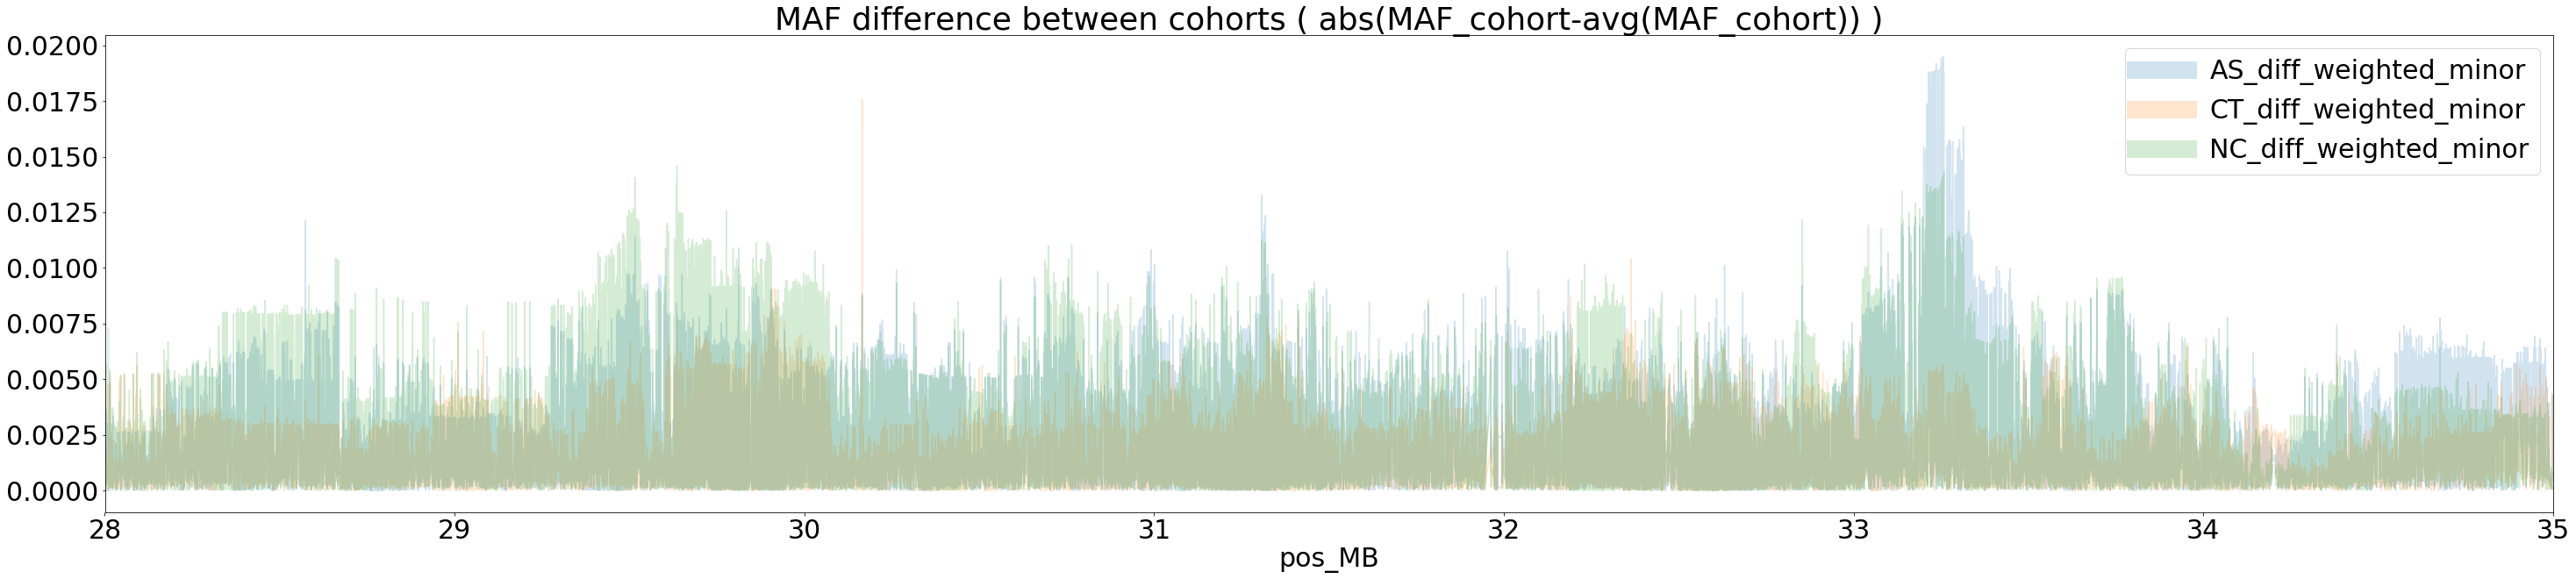

In [80]:
plt.rcParams["figure.figsize"] = (50,10)
plt.rcParams["font.size"]=30

ax=maf_df.set_index('pos_MB')[['AS_diff_weighted_minor','CT_diff_weighted_minor','NC_diff_weighted_minor']].plot(alpha=0.2)

leg = ax.legend()

for line in leg.get_lines():
    line.set_linewidth(20)

plt.title("MAF difference between cohorts ( abs(MAF_cohort-avg(MAF_cohort)) )")
plt.savefig('MAF.svg')

In [169]:
maf_df['AS'].mean(),maf_df['AS'].min(),maf_df['AS'].max()

(0.19483053254227672, 0.004732483239121861, 0.5)

In [170]:
maf_df['CT'].mean(),maf_df['CT'].min(),maf_df['CT'].max()

(0.1946544550292758, 0.004921388880484878, 0.4999848727800805)

In [171]:
maf_df['NC'].mean(),maf_df['NC'].min(),maf_df['NC'].max()

(0.19395682067393166, 0.005103929761464008, 0.5)

In [172]:
maf_df['AS_diff_weighted'].mean(),maf_df['AS_diff_weighted'].min(),maf_df['AS_diff_weighted'].max()

(0.0022412417310651704, 4.579547852046062e-10, 0.019479151573028652)

In [173]:
maf_df['CT_diff_weighted'].mean(),maf_df['CT_diff_weighted'].min(),maf_df['CT_diff_weighted'].max()

(0.001673300881159929, 1.2356453422956992e-07, 0.018359628370642617)

In [174]:
maf_df['NC_diff_weighted'].mean(),maf_df['NC_diff_weighted'].min(),maf_df['NC_diff_weighted'].max()

(0.002263989566338635, 6.980417109961334e-08, 0.01458894060723423)

MAF AS>=CT>NC

In [175]:
maf_df.shape

(74904, 11)

In [183]:
(maf_df['AS']<0.05).sum(),(maf_df['AS']<0.01).sum(),(maf_df['AS']<0.005).sum()

(15116, 237, 3)

In [186]:
(maf_df['CT']<0.05).sum(),(maf_df['CT']<0.01).sum(),(maf_df['CT']<0.005).sum()

(15187, 210, 2)

In [187]:
(maf_df['NC']<0.05).sum(),(maf_df['NC']<0.01).sum(),(maf_df['NC']<0.005).sum()

(15357, 160, 0)

In [181]:
(maf_df==0).sum()

all                 0
AS                  0
CT                  0
NC                  0
all_weighted        0
AS_diff             0
CT_diff             0
NC_diff             0
AS_diff_weighted    0
CT_diff_weighted    0
NC_diff_weighted    0
dtype: int64